In [4]:
!pip install kagglehub tensorflow keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 MB 10.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.2 MB/s eta 0:00:0000:0100:01
  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 9.5 MB/s eta 0:00:0000:01
  Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.0/398.0 kB 9.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 11.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 11.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 11.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 11.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.5 MB/s eta 0:00:00
  Using c

In [2]:
import kagglehub

while True:
    try:
        path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
    except Exception as e:
        print("ConnectionError, retrying...")
    else:
        break
print("Path to dataset files:", path)

Resuming download from 57671680 bytes (5525242831 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/kmader/skin-cancer-mnist-ham10000?dataset_version_number=2 (57671680/5582914511) bytes left.


 44%|████▍     | 2.31G/5.20G [03:49<04:53, 10.6MB/s]


ConnectionError, retrying...
Resuming download from 2479882240 bytes (3103032271 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/kmader/skin-cancer-mnist-ham10000?dataset_version_number=2 (2479882240/5582914511) bytes left.


 53%|█████▎    | 2.74G/5.20G [00:56<05:20, 8.22MB/s]


ConnectionError, retrying...
Resuming download from 2946498560 bytes (2636415951 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/kmader/skin-cancer-mnist-ham10000?dataset_version_number=2 (2946498560/5582914511) bytes left.


 73%|███████▎  | 3.80G/5.20G [01:55<02:32, 9.83MB/s]


ConnectionError, retrying...
Resuming download from 4083154944 bytes (1499759567 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/kmader/skin-cancer-mnist-ham10000?dataset_version_number=2 (4083154944/5582914511) bytes left.


100%|██████████| 5.20G/5.20G [02:12<00:00, 11.3MB/s]

Extracting files...


Path to dataset files: /Users/iavnukov/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [3]:
!mkdir ./datasets
!mv $path ./datasets/skin-cancer

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
import json

data_dir1 = "./datasets/skin-cancer/HAM10000_images_part_1"
data_dir2 = "./datasets/skin-cancer/HAM10000_images_part_2"
metadata_path = "./datasets/skin-cancer/HAM10000_metadata.csv"

metadata = pd.read_csv(metadata_path)

metadata['image_path'] = metadata['image_id'].apply(
    lambda x: os.path.join(data_dir1, f"{x}.jpg") if os.path.exists(os.path.join(data_dir1, f"{x}.jpg")) else os.path.join(data_dir2, f"{x}.jpg")
)

metadata = metadata[metadata['image_path'].apply(os.path.exists)]

label_encoder = LabelEncoder()
metadata['label'] = label_encoder.fit_transform(metadata['dx'])
num_classes = len(metadata['label'].unique())

IMG_SIZE = 128

def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    image = tf.keras.preprocessing.image.img_to_array(image)
    return image / 255.0

images = np.array([preprocess_image(img_path) for img_path in metadata['image_path']])
labels = to_categorical(metadata['label'], num_classes=num_classes)

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

EPOCHS = 50
BATCH_SIZE = 32
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[reduce_lr],
    verbose=1
)

val_predictions = model.predict(X_val)
y_val_labels = np.argmax(y_val, axis=1)
y_pred_labels = np.argmax(val_predictions, axis=1)

f1 = f1_score(y_val_labels, y_pred_labels, average='weighted')
history_data = {
    "accuracy": history.history['accuracy'],
    "val_accuracy": history.history['val_accuracy'],
    "loss": history.history['loss'],
    "val_loss": history.history['val_loss'],
    "f1_score": f1
}

/Users/iavnukov/PycharmProjects/skin-care-ai/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 30s 115ms/step - accuracy: 0.5867 - loss: 3.8017 - val_accuracy: 0.6455 - val_loss: 2.2052 - learning_rate: 0.0010
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - accuracy: 0.6544 - loss: 1.8444 - val_accuracy: 0.6760 - val_loss: 1.5751 - learning_rate: 0.0010
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.6648 - loss: 1.6923 - val_accuracy: 0.6685 - val_loss: 1.5225 - learning_rate: 0.0010
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - accuracy: 0.6733 - loss: 1.4924 - val_accuracy: 0.6805 - val_loss: 1.3496 - learning_rate: 0.0010
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 29s 114ms/step - accuracy: 0.6782 - loss: 1.3545 - val_accuracy: 0.6680 - val_loss: 1.5062 - learning_rate: 0.0010
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - accuracy: 0.6683 - loss: 1.3781 - val_accuracy: 0.6186 - val_loss: 1.8106 - learning_rate: 0.0010
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - accuracy: 0.6

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/training_progress.json'

Classification Report:
              precision    recall  f1-score   support

       akiec       0.39      0.29      0.33        69
         bcc       0.58      0.61      0.60        93
         bkl       0.54      0.48      0.51       228
          df       1.00      0.11      0.19        28
         mel       0.53      0.40      0.45       226
          nv       0.85      0.93      0.89      1338
        vasc       0.76      0.62      0.68        21

    accuracy                           0.77      2003
   macro avg       0.67      0.49      0.52      2003
weighted avg       0.75      0.77      0.75      2003



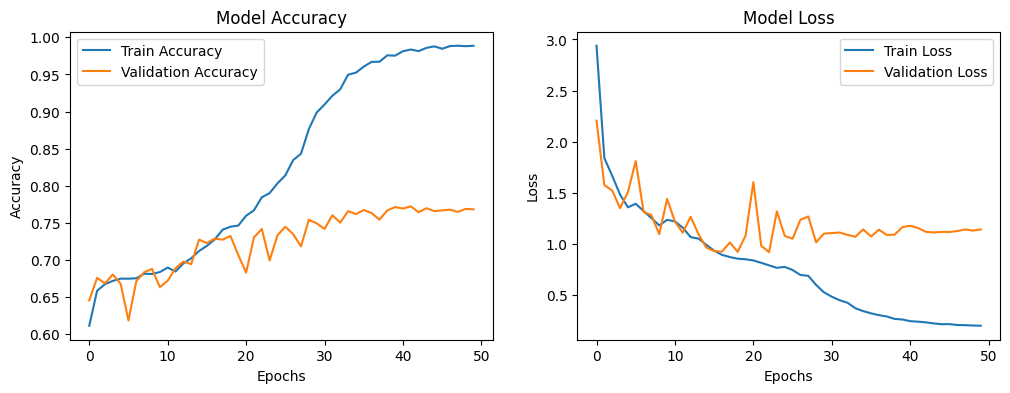

In [7]:
with open("./training_progress.json", "w") as json_file:
    json.dump(history_data, json_file)

print("Classification Report:")
print(classification_report(y_val_labels, y_pred_labels, target_names=label_encoder.classes_))

model.save("./baseline.keras")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()